day05_pytorch_nn_tool_box

In [6]:
import numpy as np
import torch
from torchvision.datasets import mnist

In [7]:
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [8]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 5
lr = 0.01
momentum = 0.5

In [9]:
#定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
#dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [10]:
print(test_loader)

## 可视化源数据

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
examples = enumerate(test_loader)

batch_idx, (example_data, example_targets) = next(examples)

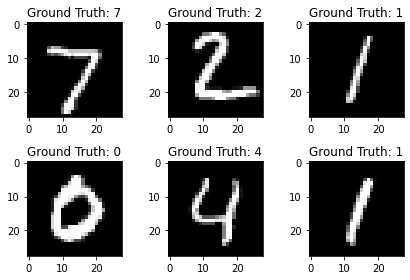

In [13]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    # plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    #plt.xticks([])
    #plt.yticks([])

In [14]:
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

## 实例化网络

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
model = Net(28*28, 300, 100, 10)

In [17]:
model.to(device)

Net(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

## 训练模型

In [20]:
# 开始训练

In [21]:
losses = []
acces = []
eval_losses = []
eval_acces = []

In [22]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []


for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 1.0291, Train Acc: 0.7807, Test Loss: 0.5584, Test Acc: 0.8968
epoch: 1, Train Loss: 0.4827, Train Acc: 0.8995, Test Loss: 0.3549, Test Acc: 0.9237
epoch: 2, Train Loss: 0.3491, Train Acc: 0.9197, Test Loss: 0.2726, Test Acc: 0.9372
epoch: 3, Train Loss: 0.2843, Train Acc: 0.9324, Test Loss: 0.2277, Test Acc: 0.9454
epoch: 4, Train Loss: 0.2415, Train Acc: 0.9419, Test Loss: 0.1984, Test Acc: 0.9506


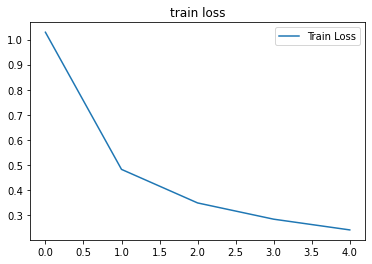

In [23]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')

In [26]:
print(optimizer.param_groups[0])

{'params': [Parameter containing:
tensor([[-0.0113, -0.0015, -0.0321,  ...,  0.0257,  0.0348, -0.0071],
        [ 0.0110, -0.0005, -0.0351,  ..., -0.0307, -0.0311, -0.0120],
        [-0.0154, -0.0332,  0.0320,  ...,  0.0157, -0.0162, -0.0056],
        ...,
        [ 0.0306, -0.0097, -0.0031,  ...,  0.0266,  0.0029, -0.0211],
        [ 0.0282,  0.0131, -0.0321,  ...,  0.0011,  0.0110, -0.0012],
        [ 0.0062,  0.0207,  0.0044,  ...,  0.0195, -0.0312, -0.0315]],
       requires_grad=True), Parameter containing:
tensor([ 9.8244e-04,  7.6345e-03,  1.3813e-02, -2.4148e-02,  2.4515e-02,
         2.2658e-02, -1.5516e-02, -3.1095e-02,  5.7560e-03, -2.7507e-02,
         2.2905e-02,  4.9885e-03,  3.5349e-02,  2.0276e-02,  9.5277e-03,
         1.9069e-02, -5.3518e-03, -6.9996e-04, -1.0057e-02, -1.0663e-02,
        -3.5336e-02,  3.0555e-02, -2.5759e-02, -9.0467e-03, -1.7324e-02,
         1.7093e-02, -3.4877e-02, -3.2402e-02,  9.6948e-03,  1.9644e-02,
        -1.7435e-02,  2.3320e-02,  1.7210e-0